# **Welcome to the Demo Notebook (*In Progress*)**

In this demo notebook we go through the `.py` modules used for the project and demonstrate their functionality.<br>


### **Step 1) The Dependencies**

The code for `package_installer` and the overall requirements module is taken from another DEDA quantlet, but amended to use pkg resources. Still, this part of the module requires more work and fine-tuning to be up-to-date with current standards. 

In [1]:
# Basic libraries
import re
import os
import gc
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### **Step 2) The Scraper**
Import the master_theses_scraper from the freshly added `thesis_scraper.py` module, docstring of which is given below. The function is constructed deliberately to produce many `print()` statements along the way to let the users know what stage of the work they are on and how this or that entry currently being processed looks like.

Also, to note, the scraping implementation is designed in a way that is specifically targeted at the HU website, meaning it will need some tinkering inside for repurposing. 


In [31]:
# Import the custom function and inspect
from thesis_scraper import master_theses_scraper 
master_theses_scraper?

Signature: master_theses_scraper(url, down_dir, headers)
Docstring:
Scrapes master's theses from a specified URL, retrieves download links, and downloads the theses.

Args:
    url (str): The URL of the webpage containing the LvB theses.
    down_dir (str): The directory where the scraped PDFs will be downloaded.
    headers (dict): HTTP headers to be used in the requests.
File:      d:\seafile\моя библиотека\2 semester\deda\github\bacha fork\deda_class_sose2023\deda_class_sose2023_lda_msc_theses\thesis_scraper.py
Type:      function

In [34]:
# Specify the link to scrape
url = 'https://www.wiwi.hu-berlin.de/de/forschung/irtg/lvb/research/dmb'

# Sets the directory for downloading our scraped pdfs
down_dir = 'OCRed PDFs/'

# Makes the directory in case it does not exist already
os.makedirs(down_dir, exist_ok = True)


# Set your own user agent here after ' User-Agent' Google: what is my user agent
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/113.0',
    'Accept-Language': 'en-US'
}

In [35]:
# Run the function:
master_theses_scraper(url = url,
                      down_dir = down_dir,
                      headers = headers
)

Scraping complete.
244 entries found.
An example entry in our links container looks like:
 <a data-linktype="external" data-val="https://edoc.hu-berlin.de/handle/18452/24455" href="https://edoc.hu-berlin.de/handle/18452/24455">Comparing Cryptocurrency Indices to Traditional Indices</a>


Identifying invalid links...
51 invalid links identified.
193 entries remain.
Identifying Master's Theses...
124 Master's Theses identified.
A sample entry looks as follows:
 <a href="https://edoc.hu-berlin.de/handle/18452/23881">App-based Forecasting of CRIX Index Returns Using R and R-Shiny</a>
Retrieving download links...
Due to missing link, dropped entry: <a href="http://edoc.hu-berlin.de/master/ristig-alexander-2012-02-03">Modelling of Vector MEM with Hierarchical Archimedean Copula</a>
Due to missing link, dropped entry: <a href="http://edoc.hu-berlin.de/master/schelisch-martin-2011-06-10">Jumps in High Frequency Data</a>
Due to missing link, dropped entry: <a href="http://edoc.hu-berlin.de/mast

## **Step 3) Pre-Processing**

1. The first thing that needs to be done is to check whether there are German language entries among our PDF files.
For this purpose, we have defined a function `de_detect` which takes as argument our directory and the files inside, scans them and removes the German entries.<br>

In [36]:
# Set folder as needed. 
folder = 'OCRed PDFs'
theses = os.listdir(folder) 


In [38]:
from lang_detect import de_detect

In [39]:
german_list = de_detect(folder, theses)

Current working directory: D:\Seafile\Моя библиотека\2 semester\DEDA\GitHub\Bacha fork\DEDA_class_SoSe2023\DEDA_class_SoSe2023_LDA_MSc_Theses
Currently working on 1.master_garcia_gonzalo.pdf_2021-08-26.
Currently working on 10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27.
10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27 was identified as German.
10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27 removed from directory
Currently working on 100.wang.pdf_2005-09-15.
Currently working on 101.zeng.pdf_2005-09-14.
Currently working on 102.gillette.pdf_2005-09-13.
Currently working on 103.ignatieva.pdf_2005-09-06.
Currently working on 104.giacomini.pdf_2005-08-17.
Currently working on 105.du-moulinet-d-hardemare.pdf_2005-01-01.
Currently working on 106.sebe-vodislav.pdf_2009-08-13.
Currently working on 107.borak.pdf_2005-05-20.
Currently working on 108.andriyashin.pdf_2005-03-24.
Currently working on 109.chen.pdf_2005-02-06.
Currently working on 11.master_agakishiev_ilyas.pdf_2019-06-07.
Currently working

In [40]:
# These two lines included inside the function from now on
print(f'We have identified in total {len(german_list)} German language documents. See below the full list:')
print(german_list)

We have identified in total 7 German language documents. See below the full list:
['10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27', '22.Masterarbeit_Frost_Oliver.pdf_2018-06-04', '60.jaehrling.pdf_2013-09-09', '87.myzickova.pdf_2007-11-14', '89.reichelt.pdf_2007-08-01', '93.ying.pdf_2007-02-22', '99.pari-schatz.pdf_2005-10-31']


In [41]:
# Clean memory
import gc
gc.collect()

531707

With $7$ papers dropped, that leaves the amount fo scraped papers at $114$, with additional $11$ sourced from CDs and scanning the physical documents.
So, we can proceed to work with the $125$ documents in total.<br>

2. Now we move on to the preprocessing part using the function `preprocess_text` from text_prep.py

What does the function do?

For every document in our directory it:
- makes text lower case
- removes non alphabetic characters
- removes stop words
- removes single-character words and other possible PDF reading mistakes
- lemmatizes words
- renders the processed theses as `.txt` files

This helps significantly reduce dimensions and get rid of noise in our data.

**Additional Functionality (Somewhat Costly):**

We have further included additional, but fairly computationally costly, funcitionality within the function that can be turned on by setting argument `verbose = True`.

Using this, the function will save and count the word tokens at every stage of the preprocessing and automately generate plots for additional insight into the dimensionality reduction process.


In [59]:
# Import function
from text_prep import preprocess_text

In [60]:
# See function arguments
preprocess_text?

Signature:
preprocess_text(
    first_input_folder=None,
    theses=None,
    inter_output_folder=None,
    verbose=False,
)
Docstring:
Preprocesses the PDF files by making everything lowercase,
getting rid of non-alphabetic words, removing stopwords,
tokenizing, lemmatizing, removing words with less than 3 character.

Args:
    first_input_folder (str): Path to the folder containing the PDF files.
    
    theses: os.listdir(folder).
            
    inter_output_folder (str): Intermediate output folder to save the filtered theses.
            
    verbose (bool): Returns vizualizations and information about dimensionality reduction. Can be set to False to save computational power, memory and time when working with large corpora of files.

Returns:
    None. Filthered theses saved in new folder.
File:      d:\seafile\моя библиотека\2 semester\deda\github\bacha fork\deda_class_sose2023\deda_class_sose2023_lda_msc_theses\text_prep.py
Type:      function

In [61]:
# Set folders as needed. 
first_input_folder = 'OCRed PDFs'
theses = os.listdir(first_input_folder) 
inter_output_folder = 'Filtered Theses'
os.makedirs(inter_output_folder, exist_ok = True)


Current working directory: D:\Seafile\Моя библиотека\2 semester\DEDA\GitHub\Bacha fork\DEDA_class_SoSe2023\DEDA_class_SoSe2023_LDA_MSc_Theses
Currently working on 1.master_garcia_gonzalo.pdf_2021-08-26.
Currently working on 100.wang.pdf_2005-09-15.
Currently working on 101.zeng.pdf_2005-09-14.
Currently working on 102.gillette.pdf_2005-09-13.
Currently working on 103.ignatieva.pdf_2005-09-06.
Currently working on 104.giacomini.pdf_2005-08-17.
Currently working on 106.sebe-vodislav.pdf_2009-08-13.
Currently working on 107.borak.pdf_2005-05-20.
Currently working on 108.andriyashin.pdf_2005-03-24.
Currently working on 109.chen.pdf_2005-02-06.
Currently working on 11.master_agakishiev_ilyas.pdf_2019-06-07.
Currently working on 110.detlefsen.pdf_2005-01-27.
Currently working on 111.benko.pdf_2004-12-20.
Currently working on 112.ulbricht.pdf_2004-08-27.
Currently working on 114.zhou.pdf_2004-07-06.
Currently working on 115.mungo.pdf_2004-05-17.
Currently working on 116.giacomini.pdf_2003-12-

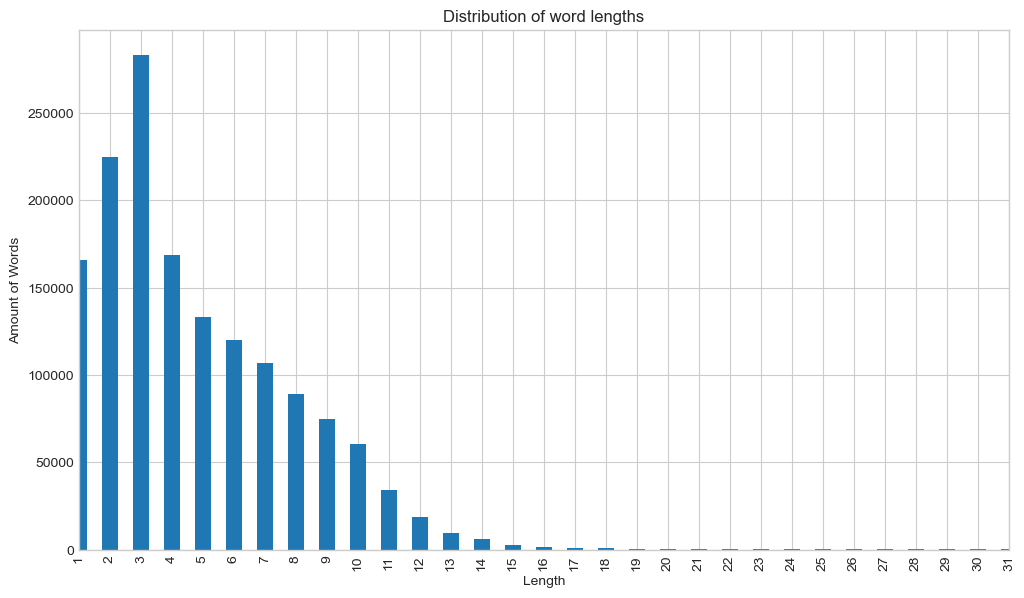



Total amount of words before dropping single character words: 1515140 




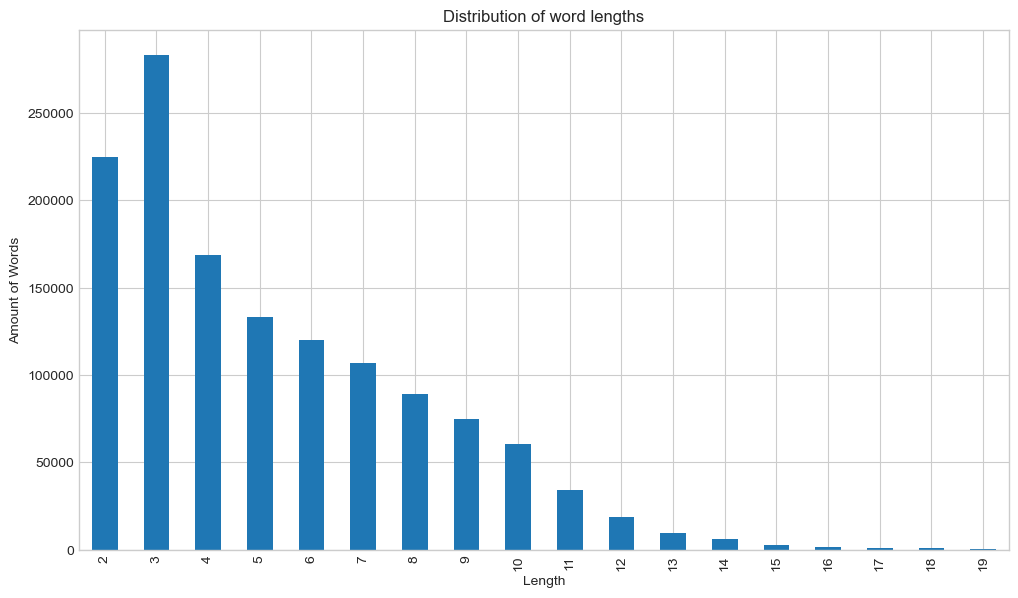



Total amount of words after dropping single character words and other pdf reader mistakes: 1336265 




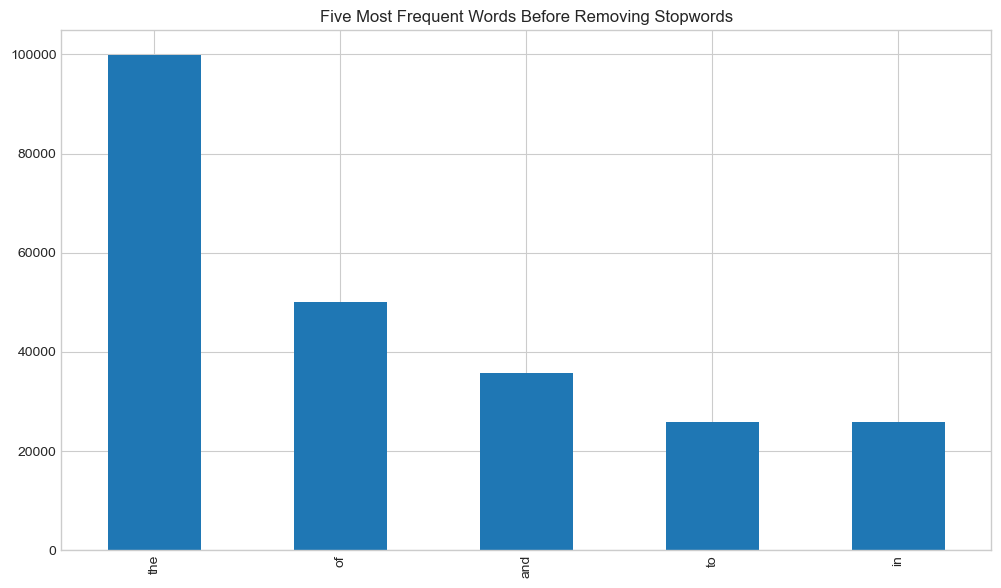



Total amount of words before removing stopwords: 1336265




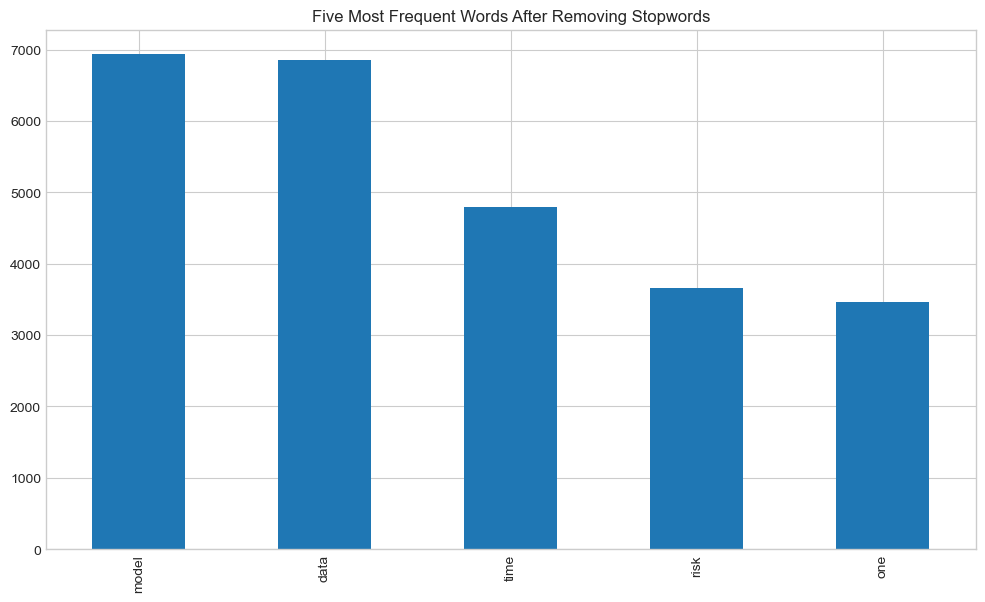



Total amount of words after removing stopwords: 823147




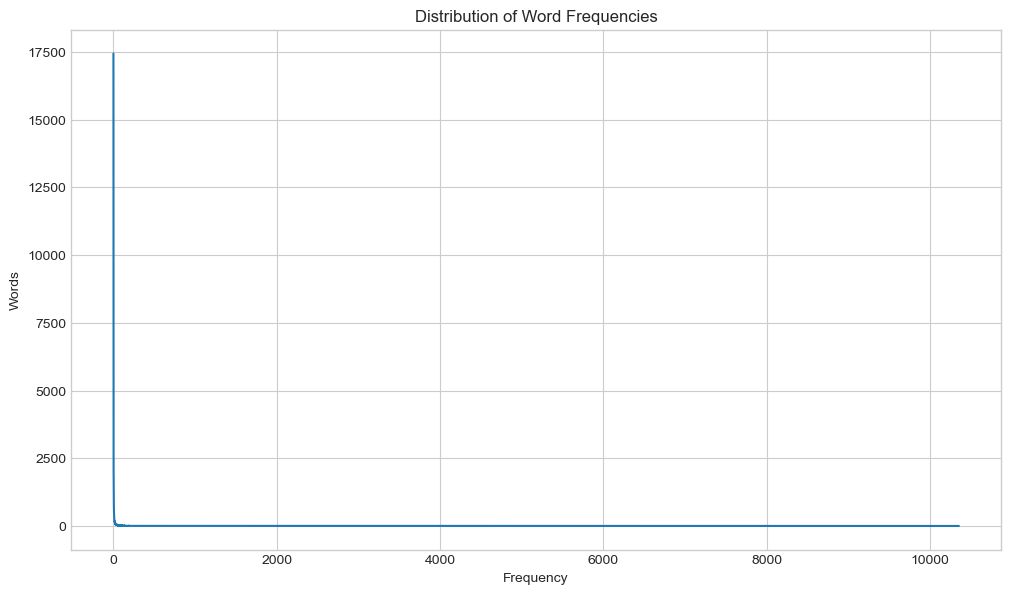

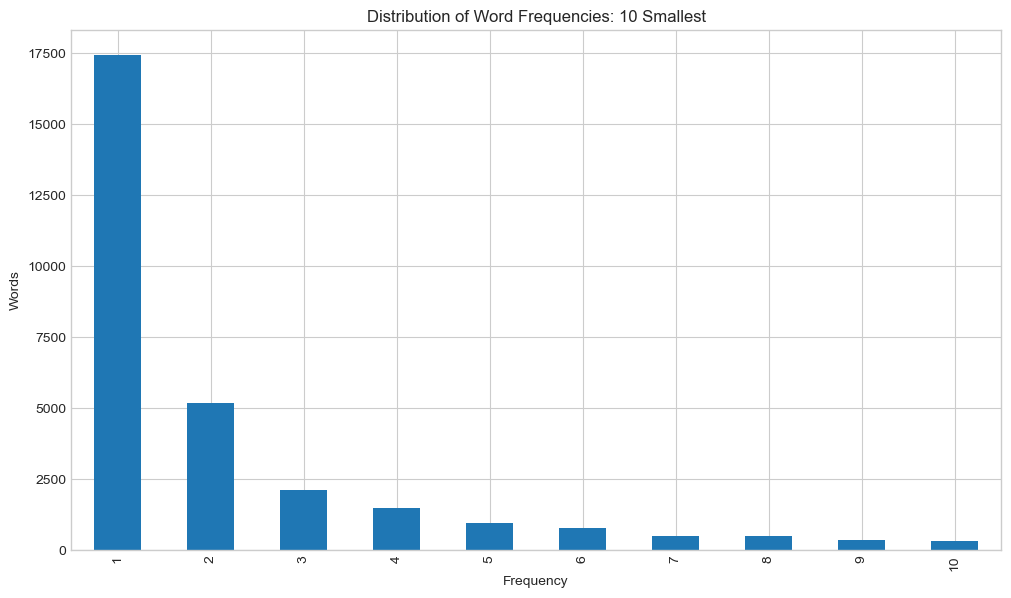



Preprocessing succesfully completed.




In [62]:
preprocess_text(first_input_folder, theses, inter_output_folder, verbose = True)


After launching the function at $17:00$, it ended at $17:48$.

***Disclaimer Note:*** <br>
Dropped `118.su.pdf` as it kept making the function freeze on any computer we tried on.

We now have $124$ MSc.

**End Result:**

We have successfully pre-processed $124$ MSc theses for LDA.

## Step 4) Making the corpus

For this we use the customly designed  `CorpusMaker` class, which includes three methods.

```python

CorpusMaker.make_corpus: 'Sets up the corpus, returns corpus, dictionary, ID mapping and texts. The returns are pickled and automatically saved to folder DICT_CORP.'
CorpusMaker.show_top_words: 'Prints selected amount of most frequent words per thesis.'
CorpusMaker.make_wordcloud: 'Generates word cloud image. The image is automatically saved to the Plots folder.'


In [2]:
# Import the class
from corpus_maker import CorpusMaker

In [3]:
# Inspect the class
CorpusMaker?

Init signature: CorpusMaker(input_folder)
Docstring:     
A class used for turning the filtered LvB MSc theses into a corpus. Generally, this class can also be used to generate a corpus from any set of .txt files that have already gone through standard NLP preprocessing. 

Outputs are saved as pickle files in automatically generated folder DICT_CORP.

Args:
    input_folder (str): The folder containing the filtered MSc theses. (Should set to the output of the preprocessing function)
    
Attributes:
    dictionary: A dictionary generated using Gensim.
    dictionary_token2id: A mapping of tokens to IDs.
    corpus: BoW corpus generated from the theses. 
    texts: All tokens (used for coherence later on)
    dates: Returns dates list for theses
    
Methods:
    make_corpus: Processes the filtered theses texts, drops rare words overall, creates corpus.
    show_top_words: Prints the most frequent words per thesis in the corpus
    make_wordcloud: Generates a wordcloud image from the co

In [4]:
corp_maker = CorpusMaker(input_folder = 'Filtered Theses')

In [5]:
dictionary, dictionary_token2id, corpus, texts, dates = corp_maker.make_corpus()

Creating corpus...
After removing 27781 rare words, total amount of words in the preprocessed texts decreased from 820920 to 793139
Corpus succesfully created.


In [6]:
corp_maker.show_top_words(amount = 5)

Thesis 1
estimate: 144
price: 126
bandwidth: 124
use: 107
option: 91

Thesis 2
portfolio: 155
return: 152
mean: 136
variance: 130
frontier: 126

Thesis 3
network: 165
function: 159
set: 81
neural: 75
neuron: 65

Thesis 4
learn: 111
md: 70
fic: 61
process: 54
booklet: 54

Thesis 5
course: 157
factor: 122
variable: 100
data: 87
student: 86

Thesis 6
md: 132
excel: 124
rex: 115
add: 96
statistical: 76

Thesis 7
function: 219
basis: 151
data: 132
spline: 129
use: 88

Thesis 8
function: 120
evalarg: 118
functional: 98
matrix: 86
coef: 86

Thesis 9
model: 250
option: 181
price: 156
hedge: 130
volatility: 125

Thesis 10
distribution: 130
density: 123
ic: 108
var: 96
estimate: 83

Thesis 11
tree: 175
data: 91
node: 91
decision: 64
class: 62

Thesis 12
model: 138
time: 94
iv: 93
one: 90
function: 80

Thesis 13
copula: 215
distribution: 91
portfolio: 47
function: 42
risk: 41

Thesis 14
copula: 259
parameter: 175
panel: 112
dependence: 98
jump: 92

Thesis 15
return: 396
market: 206
portfolio: 174

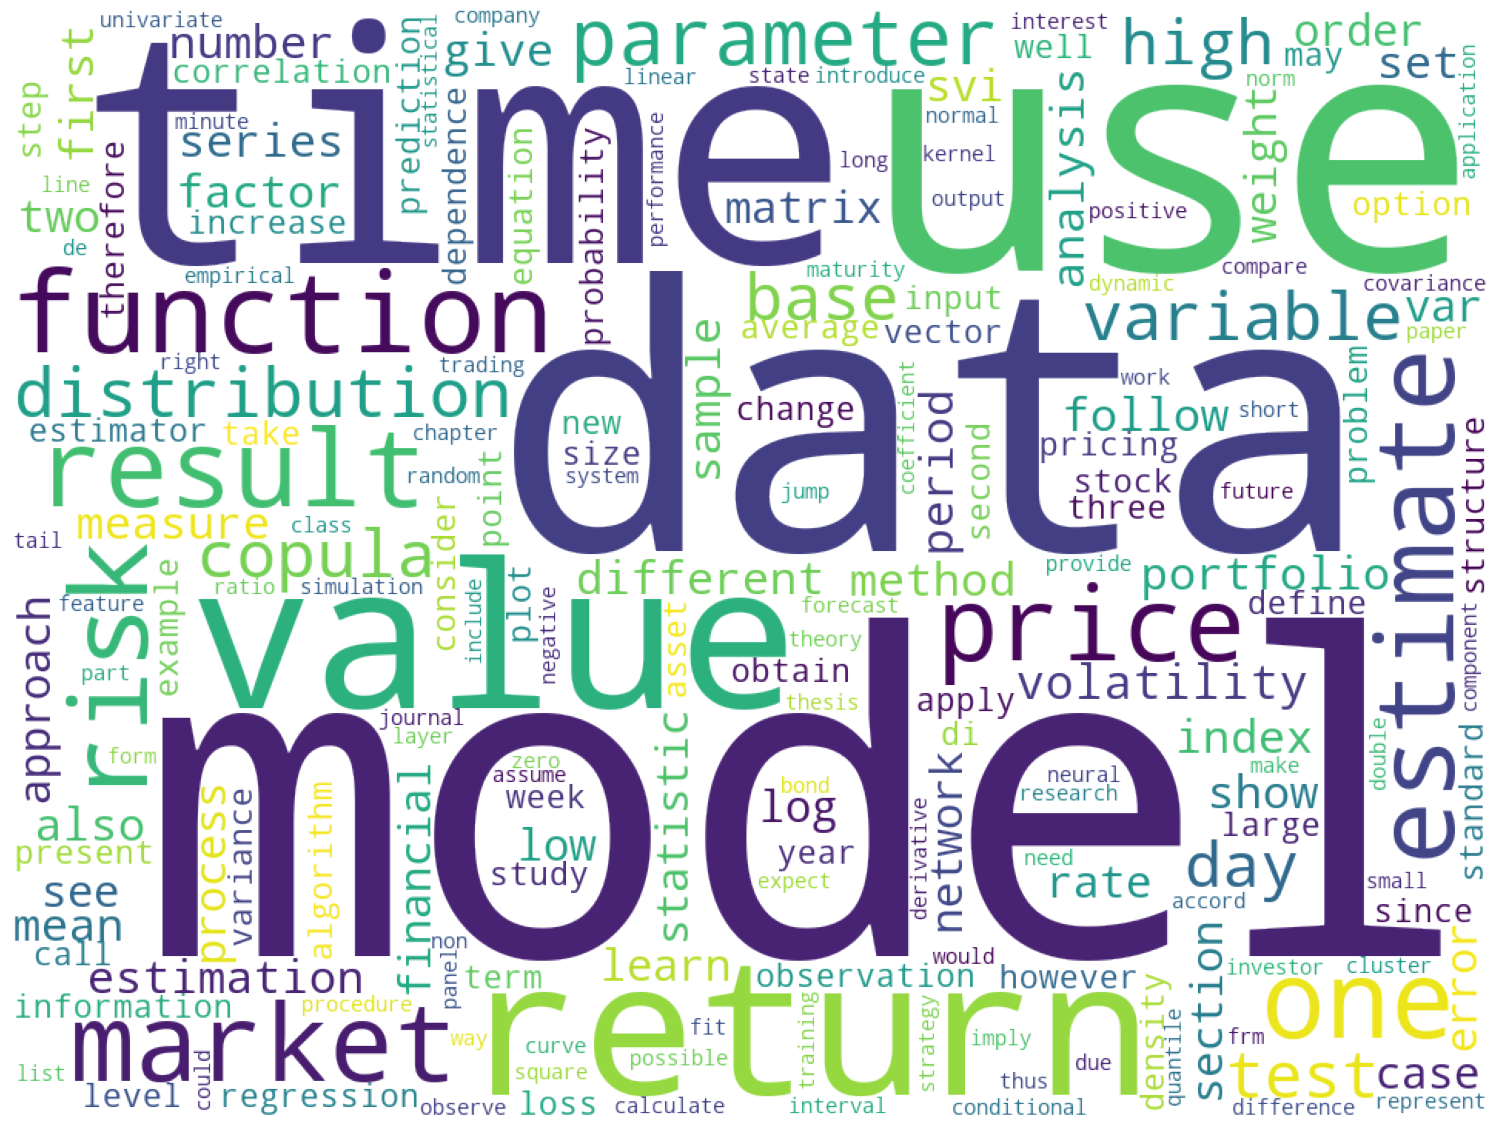

In [7]:
corp_maker.make_wordcloud()

***Disclaimer note:***

We had to manually crop thesis by `aydinli` in half since $50\%$ of the document was code.

Also, we had to manually drop two theses: `105.du-moulinet-d-hardemare.pdf` and `121.ashu.pdf`, because there was a problem with underlying text in the file, which could not be read.

We now have $122$ theses in the corpus.


## Step 5) LDA Class

We have defined a custom LDA class `LDA`, aimed at designing a simple,  user-friendly interface for carrying out LDA with grid search. 

As arguments, it takes `corpus`, `dictionary`, `texts` generated by the `CorpusMaker` class.

The class includes five methods:

```python

LDA.simple_fit(): 'Fits an LDA model with user\'s specifications.'
LDA.gird_search(): 'Carries out a grid search per user\'s specified parameters.'
LDA.lineplot_scores(): 'Plots coherence and perplexity scores per alpha and beta values and topic numbers.'
LDA.build_best_model(): 'Fits the best model obtained in grid search.'
LDA.viz(): 'Visualizes model obtained by either simple_fit or build_best_model methods.'


In [8]:
from LDA_with_Grid import LDA

In [9]:
LDA?

Init signature: LDA(corpus, dictionary, texts)
Docstring:     
A custom LDA interface designed to carry out a grid search, find the best model and vizualize it. 
Grid search carried out per coherence instead of perplexity, as optimizing for the latter may not lead to "human interpretable topics."

Args:

    corpus: A bag of words corpus (Already generated by CorpusMaker)
    dictionary: A gensim dictionary (Already generated by CorpusMaker)
    texts: All tokens (Already generated by CorpusMaker)
    
How to use:
    
    MSc_LDA = LDA(corpus, dictionary, texts) <-- initializes the class
    m = MSc_LDA.simple_fit() <-- fits one model with custom specs
    MSc_LDA.grid_search(n_topics, alphas, betas) <-- conducts grid search
    MSc_LDA.lineplot_scores() <-- plots coherence scores from grid search rounds
    m = MSc_LDA.build_best_model() <-- fits best model
    MSc_LDA.viz() <-- vizualizes best/simple model
    
File:           d:\seafile\моя библиотека\2 semester\deda\github\bacha f

### Using the `.simple_fit()`

*Note:* It is possible to run the code below directly by opening the pickled files with the code, essentially skipping the scraping and automated, as well as manual pre-processing steps.

```python
import pickle

with open('DICT_CORP/corpus.pkl', 'rb') as file:
    corpus = pickle.load(file)
    
with open('DICT_CORP/dictionary_token2id.pkl', 'rb') as file:
    dictionary_token2id = pickle.load(file)
    
with open('DICT_CORP/dictionary.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
with open('DICT_CORP/texts.pkl', 'rb') as file:
    texts = pickle.load(file)


In [10]:
# Copy the code here if needed
import pickle

with open('DICT_CORP/corpus.pkl', 'rb') as file:
    corpus = pickle.load(file)
    
with open('DICT_CORP/dictionary_token2id.pkl', 'rb') as file:
    dictionary_token2id = pickle.load(file)
    
with open('DICT_CORP/dictionary.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
with open('DICT_CORP/texts.pkl', 'rb') as file:
    texts = pickle.load(file)

with open('DICT_CORP/dates.pkl', 'rb') as file:
    dates = pickle.load(file)

In [11]:
# Initialize
MSc_LDA = LDA(corpus, dictionary, texts)

In [12]:
# Set up a single model with ten topics, alpha of 
n_top = 10
alpha_val = 'symmetric'
beta_val = 0.6

simple_m = MSc_LDA.simple_fit(n_top = n_top,
                             alpha_val = alpha_val,
                             beta_val = beta_val)



Coherence Score is: 0.45728611221078974
Perplexity Score is: -7.572008622699236


See the topics:
(0, '0.015*"model" + 0.010*"data" + 0.010*"sentiment" + 0.009*"use" + 0.009*"network" + 0.009*"learn" + 0.009*"time" + 0.008*"base" + 0.006*"training" + 0.006*"layer"')
(1, '0.015*"model" + 0.009*"copula" + 0.008*"data" + 0.007*"double" + 0.006*"use" + 0.005*"variable" + 0.005*"value" + 0.004*"factor" + 0.004*"result" + 0.004*"one"')
(2, '0.023*"return" + 0.015*"private" + 0.014*"market" + 0.014*"equity" + 0.012*"risk" + 0.010*"factor" + 0.009*"company" + 0.008*"test" + 0.008*"beta" + 0.008*"public"')
(3, '0.033*"frm" + 0.016*"risk" + 0.012*"financial" + 0.011*"model" + 0.011*"candidate" + 0.009*"market" + 0.009*"systemic" + 0.009*"institution" + 0.008*"measure" + 0.008*"america"')
(4, '0.013*"model" + 0.009*"estimate" + 0.009*"distribution" + 0.008*"copula" + 0.007*"time" + 0.007*"value" + 0.007*"use" + 0.007*"return" + 0.007*"parameter" + 0.007*"function"')
(5, '0.015*"option" + 0.015*

In [75]:
# Vizualize model
MSc_LDA.viz(model_type = 'simple') 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.000171 -0.038224       1        1  25.724632
3      0.082010  0.048227       2        1  16.558731
5      0.018548  0.029340       3        1  16.369436
9      0.058882  0.013824       4        1  12.767107
2      0.002697  0.054827       5        1   7.205679
0      0.038185 -0.009957       6        1   6.306197
6     -0.004021  0.139579       7        1   4.523813
7     -0.074297 -0.013800       8        1   3.975034
8      0.091682 -0.174783       9        1   3.608167
1     -0.213856 -0.049033      10        1   2.961203, topic_info=           Term         Freq        Total Category  logprob  loglift
463    function  4077.000000  4077.000000  Default  30.0000  30.0000
3967     copula  2707.000000  2707.000000  Default  29.0000  29.0000
801   portfolio  2216.000000  2216.000000  Default  28.0000  28.0000
923      return  4388.000000  4388.000000  Default  27.0000  27.0000
2647    network  2109.000000  2109.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
911     require    77.652652   447.789360  Topic10  -5.7119   1.7675
1150        use   101.619172  5489.258792  Topic10  -5.4429  -0.4697
830       price    93.407795  3117.033939  Topic10  -5.5272   0.0119
547       index    86.293914  1637.208640  Topic10  -5.6064   0.5766
923      return    89.591985  4388.119034  Topic10  -5.5689  -0.3718

[711 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2244      1  0.739540  accuracy
2244      2  0.019793  accuracy
2244      3  0.127755  accuracy
2244      4  0.050382  accuracy
2244      5  0.008997  accuracy
...     ...       ...       ...
7657      1  0.015893        zv
7657      3  0.921788        zv
7657      4  0.015893        zv
7657      5  0.015893        zv
7657      6  0.015893        zv

[3814 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 6, 10, 3, 1, 7, 8, 9, 2])

### Using the `.grid_search()` and `.build_best_model()`

*Note to Timur:* The grid parameter set up in the block below is just for demonstrational purposes, 

For better grid search try (even consider smaller steps with alphas and betas):

```python

n_topics = list(range(2, 20))
alphas = np.arange(0.1, 1, 0.1).tolist()
betas = np.arange(0.1, 1, 0.1).tolist()



#### 1st iteration

In [16]:

# Set up parameter grid 
#n_topics = list(range(2, 10))
#alphas = np.arange(0.1, 1, 0.2).tolist()
#betas = np.arange(0.1, 1, 0.2).tolist()
n_topics = range(2,30)
alpha = ['symmetric']
beta = ['auto']

## I append these two by hand to the gird
# because I'm not skilled enough to have included them in the upper lines of code
#alphas.append('symmetric')
#betas.append('auto')


**About the verbose argument:**

The verbose argument here just activates print statements that show the coherence score per round of the search. Even if set to false, the outputs will be saved as a CSV file. 

In [17]:
# Do the grid search
MSc_LDA.grid_search(n_topics, alpha, beta, verbose = True)

# Setting verbose = True ensures the function output 

Number of topics: 2; alpha: symmetric; beta: auto; Achieved coherence score: 0.3236646155723931
Number of topics: 3; alpha: symmetric; beta: auto; Achieved coherence score: 0.33701046741330654
Number of topics: 4; alpha: symmetric; beta: auto; Achieved coherence score: 0.3372027873432742
Number of topics: 5; alpha: symmetric; beta: auto; Achieved coherence score: 0.3277081047085527
Number of topics: 6; alpha: symmetric; beta: auto; Achieved coherence score: 0.36481444935577345
Number of topics: 7; alpha: symmetric; beta: auto; Achieved coherence score: 0.3874921572814675
Number of topics: 8; alpha: symmetric; beta: auto; Achieved coherence score: 0.3853601549116522
Number of topics: 9; alpha: symmetric; beta: auto; Achieved coherence score: 0.42909141387559674
Number of topics: 10; alpha: symmetric; beta: auto; Achieved coherence score: 0.4257948082667949
Number of topics: 11; alpha: symmetric; beta: auto; Achieved coherence score: 0.41283531993345407
Number of topics: 12; alpha: symme

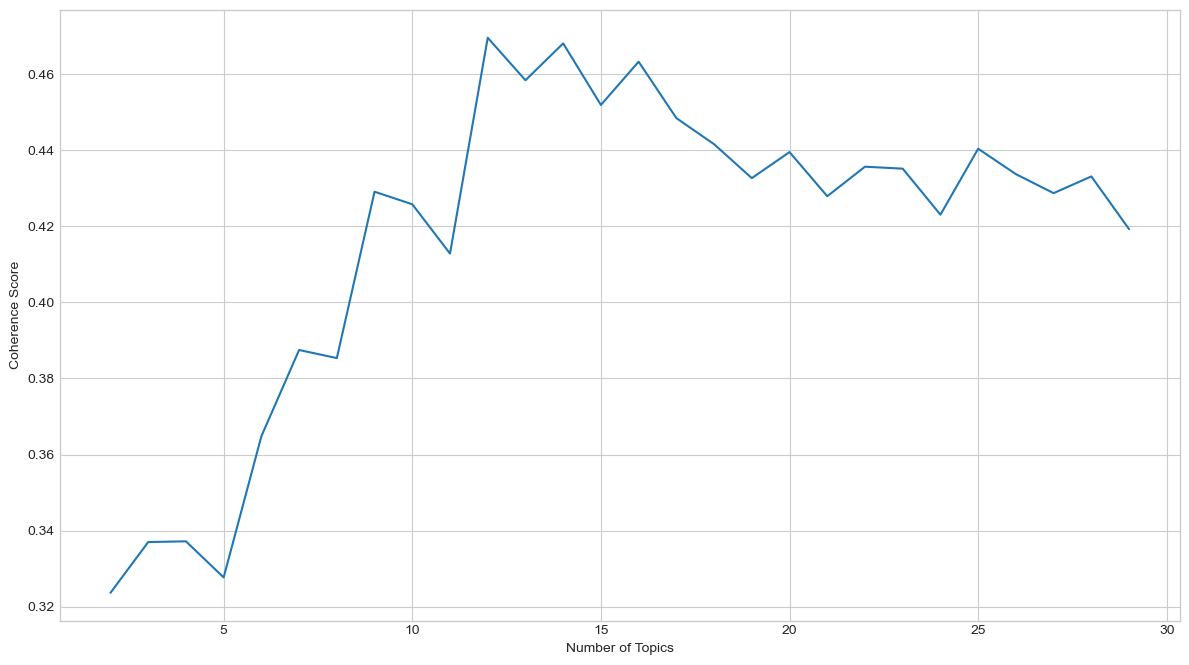

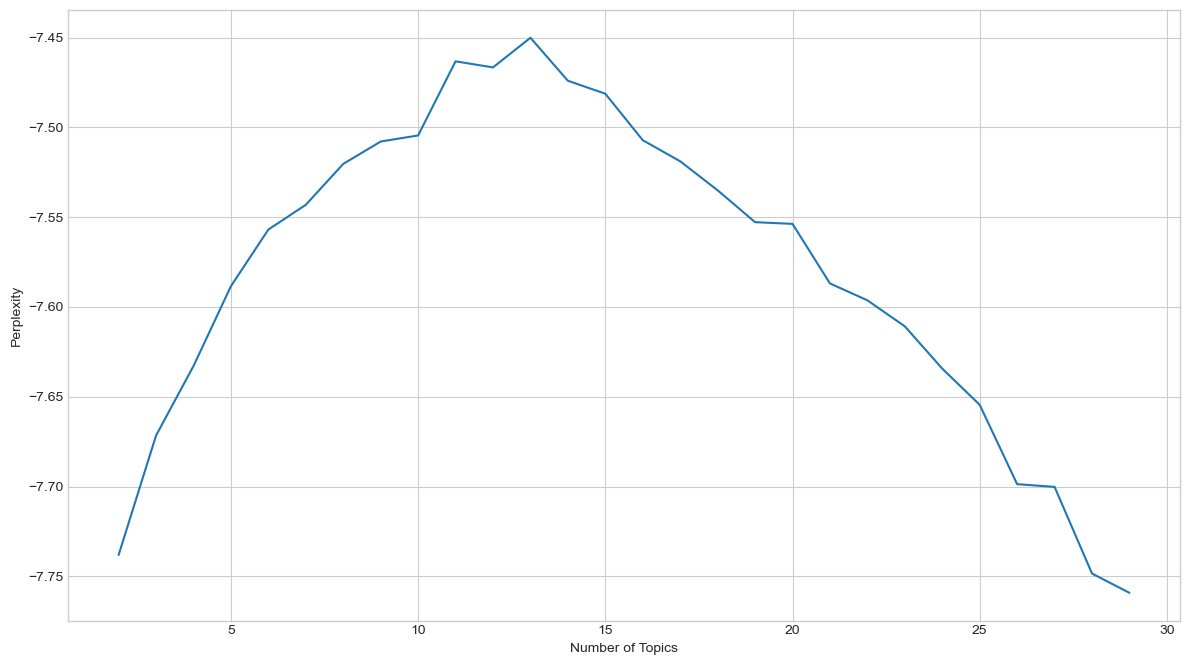

In [18]:
# Plot the scores
MSc_LDA.lineplot_scores()

***Disclaimer Note:***
The plotting functionality needs improving as it does not reflect alpha and beta values.

In [19]:
# call best model
best_m = MSc_LDA.build_best_model()

(0, '0.024*"return" + 0.018*"portfolio" + 0.017*"private" + 0.016*"equity" + 0.015*"data" + 0.015*"risk" + 0.014*"factor" + 0.012*"market" + 0.010*"company" + 0.010*"cluster"')
(1, '0.035*"copula" + 0.017*"parameter" + 0.016*"estimate" + 0.016*"distribution" + 0.014*"dependence" + 0.013*"data" + 0.013*"portfolio" + 0.012*"test" + 0.011*"interval" + 0.010*"procedure"')
(2, '0.013*"risk" + 0.011*"frm" + 0.009*"model" + 0.009*"financial" + 0.007*"market" + 0.007*"measure" + 0.007*"covar" + 0.007*"high" + 0.006*"institution" + 0.006*"regression"')
(3, '0.030*"bond" + 0.027*"loss" + 0.026*"earthquake" + 0.025*"cat" + 0.018*"model" + 0.013*"price" + 0.013*"distribution" + 0.011*"data" + 0.010*"mexico" + 0.009*"process"')
(4, '0.017*"model" + 0.012*"variable" + 0.012*"correlation" + 0.011*"default" + 0.009*"probability" + 0.008*"data" + 0.007*"tranche" + 0.007*"function" + 0.007*"loss" + 0.006*"use"')
(5, '0.028*"bond" + 0.021*"return" + 0.016*"rate" + 0.016*"risk" + 0.016*"market" + 0.014*"m

In [20]:
# Viz best model by setting model_type = 'best'
MSc_LDA.viz(model_type = 'best')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.057049 -0.000818       1        1  17.309904
8     -0.104481  0.035358       2        1  13.059521
2     -0.004336 -0.004321       3        1  11.086184
1      0.117729  0.006118       4        1   9.379941
4      0.044738  0.058393       5        1   8.095528
7     -0.134929  0.087294       6        1   7.895883
10    -0.063307 -0.023882       7        1   7.300161
6     -0.112881  0.106724       8        1   6.896449
0      0.041914  0.038956       9        1   6.051917
11    -0.117402 -0.245265      10        1   5.970347
5      0.103208 -0.034376      11        1   5.003075
3      0.172698 -0.024182      12        1   1.951088, topic_info=           Term         Freq        Total Category  logprob  loglift
3558     copula  2602.000000  2602.000000  Default  30.0000  30.0000
2544       bond  1786.000000  1786.000000  Default  29.0000  29.0000
6547        svi  1497.000000  1497.000000  Default  28.0000  28.0000
267         day  3112.000000  3112.000000  Default  27.0000  27.0000
692       model  9872.000000  9872.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
664      market    94.682072  3878.657892  Topic12  -5.0899   0.2241
1059       test    90.536002  3125.254144  Topic12  -5.1347   0.3953
370    estimate    87.146799  3814.267358  Topic12  -5.1728   0.1579
779   parameter    85.940241  2942.627830  Topic12  -5.1868   0.4034
448    function    86.116746  3916.434789  Topic12  -5.1847   0.1195

[904 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
2429       1  0.018626   abnormal
2429       6  0.726405   abnormal
2429       7  0.190914   abnormal
2429       9  0.009313   abnormal
2429      11  0.046564   abnormal
...      ...       ...        ...
4958       9  0.925338      young
10779     11  0.986489         yr
7629       3  0.968074  zbonakova
4028       5  0.242348       zone
4028      12  0.727045       zone

[2939 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 3, 2, 5, 8, 11, 7, 1, 12, 6, 4])

#### 2nd iteration

In [23]:
# Set up parameter grid 

n_topics = range(12,18)
alphas = np.arange(0.1, 1, 0.2).tolist()
betas = np.arange(0.1, 1, 0.2).tolist()

## I append these two by hand to the gird
# because I'm not skilled enough to have included them in the upper lines of code
alphas.append('symmetric')
betas.append('auto')

In [24]:
# Do the grid search
MSc_LDA.grid_search(n_topics, alphas, betas, verbose = True)

# Setting verbose = True ensures the function output 

Number of topics: 12; alpha: 0.1; beta: 0.1; Achieved coherence score: 0.46581140893681333
Number of topics: 12; alpha: 0.1; beta: 0.30000000000000004; Achieved coherence score: 0.472272285468133
Number of topics: 12; alpha: 0.1; beta: 0.5000000000000001; Achieved coherence score: 0.4734572057995494
Number of topics: 12; alpha: 0.1; beta: 0.7000000000000001; Achieved coherence score: 0.4715771657474665
Number of topics: 12; alpha: 0.1; beta: 0.9000000000000001; Achieved coherence score: 0.4737110707762539
Number of topics: 12; alpha: 0.1; beta: auto; Achieved coherence score: 0.4695597212242612
Number of topics: 12; alpha: 0.30000000000000004; beta: 0.1; Achieved coherence score: 0.4658114089368133
Number of topics: 12; alpha: 0.30000000000000004; beta: 0.30000000000000004; Achieved coherence score: 0.4726424287831512
Number of topics: 12; alpha: 0.30000000000000004; beta: 0.5000000000000001; Achieved coherence score: 0.4732742230030551
Number of topics: 12; alpha: 0.30000000000000004;

In [25]:
# call best model
best_m = MSc_LDA.build_best_model()

(0, '0.026*"private" + 0.023*"equity" + 0.023*"return" + 0.015*"company" + 0.013*"public" + 0.013*"beta" + 0.012*"test" + 0.011*"firm" + 0.010*"market" + 0.009*"risk"')
(1, '0.040*"copula" + 0.016*"dependence" + 0.014*"estimate" + 0.014*"parameter" + 0.013*"portfolio" + 0.013*"data" + 0.010*"procedure" + 0.009*"time" + 0.009*"exceedance" + 0.008*"distribution"')
(2, '0.013*"risk" + 0.010*"frm" + 0.009*"model" + 0.008*"financial" + 0.007*"var" + 0.007*"market" + 0.006*"measure" + 0.006*"covar" + 0.006*"institution" + 0.005*"quantile"')
(3, '0.011*"model" + 0.009*"test" + 0.008*"value" + 0.007*"double" + 0.007*"distribution" + 0.007*"data" + 0.006*"use" + 0.005*"jump" + 0.005*"time" + 0.005*"parameter"')
(4, '0.022*"correlation" + 0.016*"default" + 0.015*"model" + 0.015*"tranche" + 0.012*"loss" + 0.008*"cdo" + 0.007*"spread" + 0.006*"imply" + 0.006*"rate" + 0.006*"market"')
(5, '0.031*"bond" + 0.013*"model" + 0.013*"earthquake" + 0.013*"loss" + 0.012*"cat" + 0.011*"risk" + 0.010*"return"

In [26]:
# Viz best model by setting model_type = 'best'
MSc_LDA.viz(model_type = 'best')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.142730  0.043882       1        1  21.349408
12    -0.081970  0.001741       2        1  16.983604
8     -0.096211 -0.076102       3        1  12.751024
3     -0.010256  0.034085       4        1  11.340453
2     -0.041413  0.008923       5        1  10.036862
1      0.008068  0.134596       6        1   5.062783
6     -0.041158 -0.038735       7        1   4.968087
11     0.124475 -0.024460       8        1   4.343932
5     -0.094333  0.062810       9        1   3.626556
10    -0.025199 -0.178828      10        1   3.144213
0     -0.020913 -0.008922      11        1   2.719655
4      0.021917  0.037993      12        1   2.607295
13     0.197172  0.008103      13        1   0.812478
7      0.202551 -0.005087      14        1   0.253650, topic_info=          Term         Freq        Total Category  logprob  loglift
3558    copula  1681.000000  1681.000000  Default  30.0000  30.0000
267        day  2443.000000  2443.000000  Default  29.0000  29.0000
921     return  3546.000000  3546.000000  Default  28.0000  28.0000
2544      bond  1095.000000  1095.000000  Default  27.0000  27.0000
6547       svi   946.000000   946.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
3578  downward     1.245542    58.460676  Topic14  -7.3807   2.1282
3081   neutral     1.766571   487.110845  Topic14  -7.0312   0.3575
6438    google     1.408049   156.949910  Topic14  -7.2580   1.2632
657       main     1.362617   397.267194  Topic14  -7.2908   0.3018
2655  database     1.157846   177.850462  Topic14  -7.4537   0.9426

[883 rows x 6 columns], token_table=      Topic      Freq Term
term                      
6         1  0.080575   ac
6         2  0.012086   ac
6         3  0.004029   ac
6         4  0.072517   ac
6         5  0.068489   ac
...     ...       ...  ...
1182      9  0.009622   zu
1182     10  0.331962   zu
1182     11  0.009622   zu
1182     12  0.024055   zu
1182     13  0.004811   zu

[6580 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 13, 9, 4, 3, 2, 7, 12, 6, 11, 1, 5, 14, 8])

# Dynamic Topic Modelling

In [19]:
#creates slice for DTM
#slice is a number of topics in a time period (here: in a year)

year_counts = {}
for item in dates:
    year = item[0]
    if year in year_counts:
        year_counts[year] += 1
    else:
        year_counts[year] = 1

time_slice = list(year_counts.values())

time_slice

[1, 2, 5, 11, 2, 6, 2, 10, 2, 1, 9, 5, 8, 16, 4, 5, 8, 7, 6, 7, 4, 1]

In [29]:
year_counts
year_batches = [range(2002,2009), range(2009,2016), range(2016, 2020), range(2020, 2024)]
year_batches = [list(item) for item in year_batches]

year_batches

[[2002, 2003, 2004, 2005, 2006, 2007, 2008],
 [2009, 2010, 2011, 2012, 2013, 2014, 2015],
 [2016, 2017, 2018, 2019],
 [2020, 2021, 2022, 2023]]

In [40]:
year_counts
batches_counts = {0: 0, 1:0, 2:0, 3:0}
for key, value in year_counts.items():
    for index, batch in enumerate(year_batches):
        if int(key) in batch:
            batches_counts[index] += value

2002 1
2003 2
2004 5
2005 11
2006 2
2007 6
2008 2
2009 10
2010 2
2011 1
2012 9
2013 5
2014 8
2015 16
2016 4
2017 5
2018 8
2019 7
2020 6
2021 7
2022 4
2023 1


In [43]:
print(sum(batches_counts.values()))
batches_counts

122


{0: 29, 1: 51, 2: 24, 3: 18}

In [ ]:
from gensim.models import LdaSeqModel

ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=list(batches_counts.values()), num_topics=14)